In [92]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
# Import raw data
diabetes = pd.read_csv('diabetes_prediction_dataset.csv')

In [94]:
# Print the first 6 rows
print(diabetes.head(6))

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   
5  Female  20.0             0              0           never  27.32   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
5          6.6                   85         0  


In [95]:
# Basic information of the dataset
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None


The output indicates that the dataset has no missing value.

In [96]:
# Extracting numerical features
num_cols = diabetes.drop(columns = ['diabetes']).select_dtypes(exclude = ['bool', 'object']).columns # drop 'diabetes because it's the feature
print(num_cols)

# Extracting categorical features
cat_cols = diabetes.select_dtypes(include = ['object']).columns
print(cat_cols)

Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level'],
      dtype='object')
Index(['gender', 'smoking_history'], dtype='object')


In [97]:
# Summary statistics for nummerical columns
print(diabetes.describe())

                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.636783   
min         0.080000       0.00000       0.000000      10.010000   
25%        24.000000       0.00000       0.000000      23.630000   
50%        43.000000       0.00000       0.000000      27.320000   
75%        60.000000       0.00000       0.000000      29.580000   
max        80.000000       1.00000       1.000000      95.690000   

         HbA1c_level  blood_glucose_level       diabetes  
count  100000.000000        100000.000000  100000.000000  
mean        5.527507           138.058060       0.085000  
std         1.070672            40.708136       0.278883  
min         3.500000            80.000000       0.000000  
25%         4.800000           100.000000       0.000000  
50%         5.800000           14

### Data Cleaning

1. If duplications exist in our dataset, we would like to remove them

In [98]:
## Counting duplicated records
duplicates_num = diabetes.duplicated(keep = False).sum()
print("The number of duplicates in the data set is: ", duplicates_num)


The number of duplicates in the data set is:  6939


In [99]:
# Dropping duplicates
diabetes = diabetes.drop_duplicates()

2. The categories 'Other' in the feature 'gender' and 'No Info' in the feature 'smoking_history' may not be useful for our analysis, we would like to remove them.

In [100]:
# Relative frequency for the feature 'gender'
print((diabetes['gender'].value_counts()*100/len(diabetes)).round(2))

gender
Female    58.41
Male      41.57
Other      0.02
Name: count, dtype: float64


The 'gender' column is now binary, we would like to convert it to an integer feature.

In [101]:
diabetes['gender'] = diabetes['gender'].map({'male': 1, 'female': 0})

In [102]:
# Relative frequency for the feature 'smoking_history'
print((diabetes['smoking_history'].value_counts()*100/len(diabetes)).round(2))

smoking_history
never          35.78
No Info        34.21
former          9.67
current         9.57
not current     6.62
ever            4.16
Name: count, dtype: float64


Since the group 'Other' represents only 0.02% of our dataset, we can exclude all rows where the value 'Other' appears in the 'gender' column.

In [103]:
diabetes_cleaned = diabetes[diabetes['gender'] != 'Other']

The 'No info' value in the 'smoking_history' column accounts for 34.21% of our data, we need to remove the entire feature instead.

In [104]:
diabetes_cleaned = diabetes_cleaned.drop(columns = ['smoking_history'])

In [105]:
# The shape of our cleaned data
print('The shape of the cleaned dataset is:', diabetes_cleaned.shape)

The shape of the cleaned dataset is: (96146, 8)


### Exploring class imbalnce

In [106]:
print("The relative frequency of each class in the target:")
relative_frequency = (diabetes_cleaned[['diabetes']].value_counts() * 100 / len(diabetes_cleaned)).round(2)
print(relative_frequency)

The relative frequency of each class in the target:
diabetes
0           91.18
1            8.82
Name: count, dtype: float64


The dataset in severly imbalanced with the majority class being negative (92%). Does additional performance metrics such as f1-score is essential during the model evaluation phase.

### Preprocessing data for modelling

In [107]:
# Define features and label
X = diabetes_cleaned.drop(columns = ['diabetes'])
y = diabetes_cleaned['diabetes']

# Split dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('The shape of the training features: ', X_train.shape)
print('The shape of the training target: ', y_train.shape)
print('The shape of the testing features: ', X_test.shape)
print('The shape of the testing target: ', y_test.shape)

The shape of the training features:  (76916, 7)
The shape of the training target:  (76916,)
The shape of the testing features:  (19230, 7)
The shape of the testing target:  (19230,)


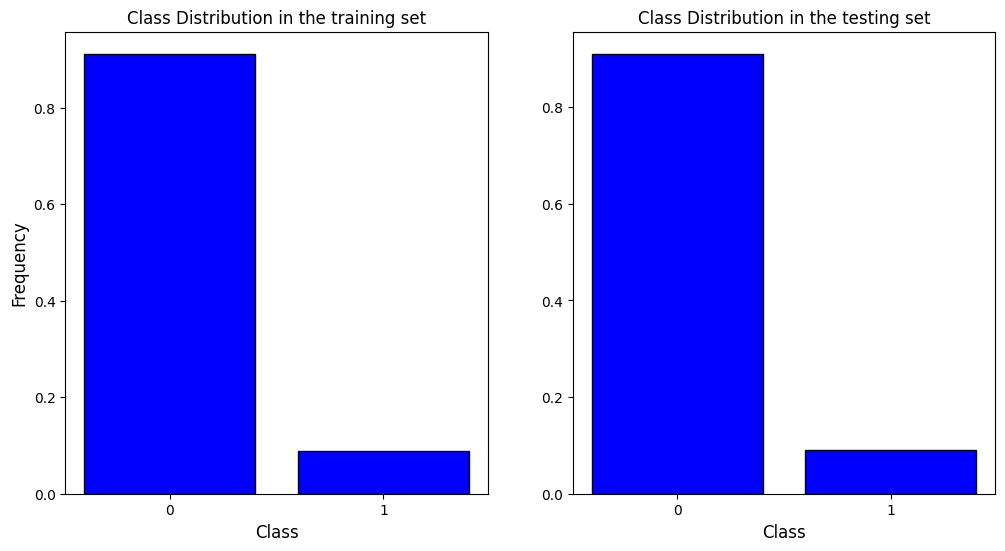

In [108]:
# Exploring the distribution of the target in both the training and testing set
# Convert data to relative frequency
y_train_counts = np.bincount(y_train) / len(y_train)  # Relative frequency for y_train
y_test_counts = np.bincount(y_test) / len(y_test)    # Relative frequency for y_test

# Create a figure with 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for y_train
axes[0].bar([0, 1], y_train_counts, color='blue', edgecolor='black')
axes[0].set_title("Class Distribution in the training set")
axes[0].set_xlabel("Class", fontsize = 12)
axes[0].set_ylabel("Frequency", fontsize = 12)
axes[0].set_xticks([0, 1]) 

# Plot histogram for y_test
axes[1].bar([0, 1], y_test_counts, color = 'blue', edgecolor='black')
axes[1].set_title("Class Distribution in the testing set")
axes[1].set_xlabel("Class", fontsize = 12)
axes[1].set_xticks([0, 1])

The class distribution is consistent across training and testing dataset.

In [109]:
# Feature scaling

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])